# COMP 472 Assignment 2
## Team: RoboCops
### Team Members:
- Rongxi Meng (40045067)
- Chen Qian (27867808)

## 2.2 Task 1: Evaluation of the word2vec-google-news-300 Pre-trained Model
In this first experiment, you will use the pre-trained Word2Vec model called word2vec-google-news-300 to 
compute the closest synonym for each word in the dataset.
 First, use gensim.downloader.load to load th 
word2vec-google-news-300 pre-trained embedding model. Then use the similarity meth d from Gensim  o
compute the cosine similarity between 2 embeddings (2 vectors) and find the closest synonym to the questioned.

In [37]:
import gensim.downloader as api
import pandas as pd
from gensim.models import KeyedVectors

In [38]:
word2vec_model = api.load("word2vec-google-news-300")

In [39]:
# Load your CSV file into a pandas DataFrame
df = pd.read_csv('./datasets/synonym.csv')

In [40]:
df

,question,answer,0,1,2,3
0,enormously,tremendously,appropriately,uniquely,tremendously,decidedly
1,provisions,stipulations,stipulations,interrelations,jurisdictions,interpretations
2,haphazardly,randomly,dangerously,densely,randomly,linearly
3,prominent,conspicuous,battered,ancient,mysterious,conspicuous
4,zenith,pinnacle,completion,pinnacle,outset,decline
...,...,...,...,...,...,...
75,fashion,manner,ration,fathom,craze,manner
76,marketed,sold,frozen,sold,sweetened,diluted
77,bigger,larger,steadier,closer,larger,better
78,roots,origins,origins,rituals,cure,function


In [41]:
# Define a function to find the closest synonym using the word2vec model and label the prediction
def find_synonym_and_label(row, model):
    question_word = row['question']
    correct_answer = row['answer']
    choices = row[['0', '1', '2', '3']].values
    synonym_found = False
    label = 'guess'
    
    # Check if the question word is in the model's vocabulary
    if question_word in model.key_to_index:
        # Check each choice to see if it's in the model's vocabulary
        valid_choices = [choice for choice in choices if choice in model.key_to_index]
        if valid_choices:
            # Use the model to predict the most similar word from the valid choices
            most_similar = model.most_similar_to_given(question_word, valid_choices)
            synonym_found = True
            # Determine if the model's choice is correct
            label = 'correct' if most_similar == correct_answer else 'wrong'
    
    # Return the model's choice if a valid synonym was found, otherwise None
    predicted_synonym = most_similar if synonym_found else None
    return pd.Series([predicted_synonym, label])

In [42]:
# Apply the function to the DataFrame
df[['predicted_synonym', 'label']] = df.apply(lambda row: find_synonym_and_label(row, word2vec_model), axis=1)

In [43]:
# Select and order the columns as specified
df_output = df[['question', 'answer', 'predicted_synonym', 'label']]

In [44]:
# Save the DataFrame with the predicted synonyms and labels to a CSV file
output_file_path = './output/task_1/word2vec-google-news-300-details.csv'
df_output.to_csv(output_file_path, index=False, header=False)

In [45]:
print(df_output.head())

      question        answer predicted_synonym    label
0   enormously  tremendously      tremendously  correct
1   provisions  stipulations      stipulations  correct
2  haphazardly      randomly          randomly  correct
3    prominent   conspicuous       conspicuous  correct
4       zenith      pinnacle          pinnacle  correct


In [46]:
# Calculate the number of correct labels
num_correct = (df_output['label'] == 'correct').sum()

# Calculate the number of questions answered without guessing
num_answered = (df_output['label'] != 'guess').sum()

# Calculate the accuracy of the model
accuracy = num_correct / num_answered if num_answered > 0 else 0

# Get the size of the vocabulary of the model
vocab_size = len(word2vec_model)

In [47]:
# Prepare the data for the analysis.csv file
task_1_analysis_data = {
    'model_name': 'word2vec-google-news-300',
    'vocab_size': vocab_size,
    'num_correct': num_correct,
    'num_answered': num_answered,
    'accuracy': accuracy
}

# Convert the analysis data to a DataFrame
df_task_1_analysis = pd.DataFrame([task_1_analysis_data])

# Save the analysis DataFrame to a CSV file
df_task_1_analysis.to_csv('./output/task_1/analysis.csv', index=False, header=False)

In [48]:
df_task_1_analysis

,model_name,vocab_size,num_correct,num_answered,accuracy
0,word2vec-google-news-300,3000000,70,79,0.886076


## 2.3 Task 2: Comparison with Other Pre-trained Models:

In [49]:
# Define a function to predict synonyms using a model and evaluate the accuracy
def predict_and_evaluate(model_name, model, df):
    def get_prediction(row):
        question_word = row['question']
        choices = [row[str(i)] for i in range(4)]
        if question_word in model.key_to_index:
            valid_choices = [choice for choice in choices if choice in model.key_to_index]
            if valid_choices:
                predicted_synonym = model.most_similar_to_given(question_word, valid_choices)
                label = 'correct' if predicted_synonym == row['answer'] else 'wrong'
                return question_word, row['answer'], predicted_synonym, label
        return question_word, row['answer'], None, 'guess'

    # Create a new DataFrame to store the detailed results
    detailed_results = df.apply(get_prediction, axis=1, result_type='expand')
    detailed_results.columns = ['question', 'answer', 'predicted_synonym', 'label']

    # Save the detailed results to a CSV file
    detailed_results.to_csv(f"./output/task_2/{model_name}-details.csv", index=False)

    # Calculate and return the accuracy
    correct = detailed_results['label'] == 'correct'
    guessed = detailed_results['label'] != 'guess'
    accuracy = correct.sum() / guessed.sum() if guessed.sum() > 0 else 0

    return {
        'model_name': model_name,
        'vocab_size': len(model.key_to_index),
        'num_correct': correct.sum(),
        'num_answered': guessed.sum(),
        'accuracy': accuracy
    }

In [50]:
# Model names according to the gensim downloader API
model_names = ['glove-wiki-gigaword-300', 'fasttext-wiki-news-subwords-300', 'glove-twitter-25', 'glove-twitter-50']

In [51]:
# Load the pre-trained models (placeholders for the actual model names)
models = {
    'glove-wiki-gigaword-300': api.load(model_names[0]),
    'fasttext-wiki-news-subwords-300': api.load(model_names[1]),
    'glove-twitter-25': api.load(model_names[2]),
    'glove-twitter-50': api.load(model_names[3]),
}

In [52]:
# Evaluate each model
results = [df_task_1_analysis.iloc[0].to_dict()]  # Start with the analysis from task 1
for model_name, model in models.items():
    results.append(predict_and_evaluate(model_name, model, df))

In [53]:
# Convert the results to a DataFrame and save to CSV
df_task_2_analysis = pd.DataFrame(results)
df_task_2_analysis.to_csv('./output/task_2/analysis.csv', index=False, header=False)

In [54]:
df_task_2_analysis

,model_name,vocab_size,num_correct,num_answered,accuracy
0,word2vec-google-news-300,3000000,70,79,0.886076
1,glove-wiki-gigaword-300,400000,71,80,0.887500
2,fasttext-wiki-news-subwords-300,999999,74,80,0.925000
3,glove-twitter-25,1193514,36,78,0.461538
4,glove-twitter-50,1193514,36,78,0.461538


## 2.4 Task 3: Train your Own Models

In [55]:
import gensim
import string
import os
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

In [56]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chenq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chenq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Split text into sentences
    sentences = nltk.sent_tokenize(text)
    # Tokenize each sentence into words and remove stopwords
    stop_words = set(stopwords.words('english'))
    processed_sentences = [[word for word in nltk.word_tokenize(sentence) if word not in stop_words] for sentence in sentences]
    return processed_sentences

In [58]:
# Directory containing your book files
book_directory = './books/'

In [59]:
# Read and preprocess each book
all_sentences = []
for filename in os.listdir(book_directory):
    if filename.endswith('.txt'):
        file_path = os.path.join(book_directory, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            all_sentences.extend(preprocess_text(text))

In [60]:
# Initialize a DataFrame with the analysis result values in it
df_task_3_analysis = df_task_2_analysis

In [61]:
# Window sizes and embedding sizes
window_sizes = [5, 10]  # W1, W2
embedding_sizes = [100, 200]  # E5, E6
model_results = []

In [62]:
# reset the df for model testing
df = pd.read_csv('./datasets/synonym.csv')

In [63]:
def predict_and_evaluate_task_3(model_name, model, df):
    def get_prediction(row):
        question_word = row['question']
        choices = [row[str(i)] for i in range(4)]
        label = 'guess'
        predicted_synonym = None

        if question_word in model.wv.key_to_index:
            valid_choices = [choice for choice in choices if choice in model.wv.key_to_index]
            if valid_choices:
                predicted_synonym = model.wv.most_similar_to_given(question_word, valid_choices)
                label = 'correct' if predicted_synonym == row['answer'] else 'wrong'
        return question_word, row['answer'], predicted_synonym, label

    detailed_results = df.apply(lambda row: get_prediction(row), axis=1, result_type='expand')
    detailed_results.columns = ['question', 'answer', 'predicted_synonym', 'label']
    detailed_results.to_csv(f"./output/task_3/{model_name}-details.csv", index=False)

    correct = detailed_results['label'] == 'correct'
    guessed = detailed_results['label'] != 'guess'
    accuracy = correct.sum() / guessed.sum() if guessed.sum() > 0 else 0

    return {
        'model_name': model_name,
        'vocab_size': len(model.wv.key_to_index),
        'num_correct': correct.sum(),
        'num_answered': guessed.sum(),
        'accuracy': accuracy
    }


In [64]:
# Train Word2Vec models with different configurations
for window_size in window_sizes:
    for  embedding_size in embedding_sizes:
        model = Word2Vec(sentences=all_sentences, vector_size=embedding_size, window=window_size, min_count=1, workers=4)
        model_name = f"Word2Vec-E{embedding_size}-W{window_size}"

        # Evaluate the model using your predict_and_evaluate_task_3 function
        results = predict_and_evaluate_task_3(model_name, model, df)

        # Append the results to the model_results list
        model_results.append(results)

In [65]:
# Create a DataFrame with the results
df_model_results = pd.DataFrame(model_results)

In [66]:
# Append the results of these models to df_task_3_analysis DataFrame
df_task_3_analysis = pd.concat([df_task_3_analysis, df_model_results], ignore_index=True)

In [67]:
# Convert the results to a DataFrame and save to CSV
df_task_3_analysis.to_csv('./output/task_3/analysis.csv', index=False, header=False)

In [70]:
df_task_3_analysis

,model_name,vocab_size,num_correct,num_answered,accuracy
0,word2vec-google-news-300,3000000,70,79,0.886076
1,glove-wiki-gigaword-300,400000,71,80,0.887500
2,fasttext-wiki-news-subwords-300,999999,74,80,0.925000
3,glove-twitter-25,1193514,36,78,0.461538
4,glove-twitter-50,1193514,36,78,0.461538
5,Word2Vec-E100-W5,145818,20,77,0.259740
6,Word2Vec-E200-W5,145818,23,77,0.298701
7,Word2Vec-E100-W10,145818,23,77,0.298701
8,Word2Vec-E200-W10,145818,23,77,0.298701


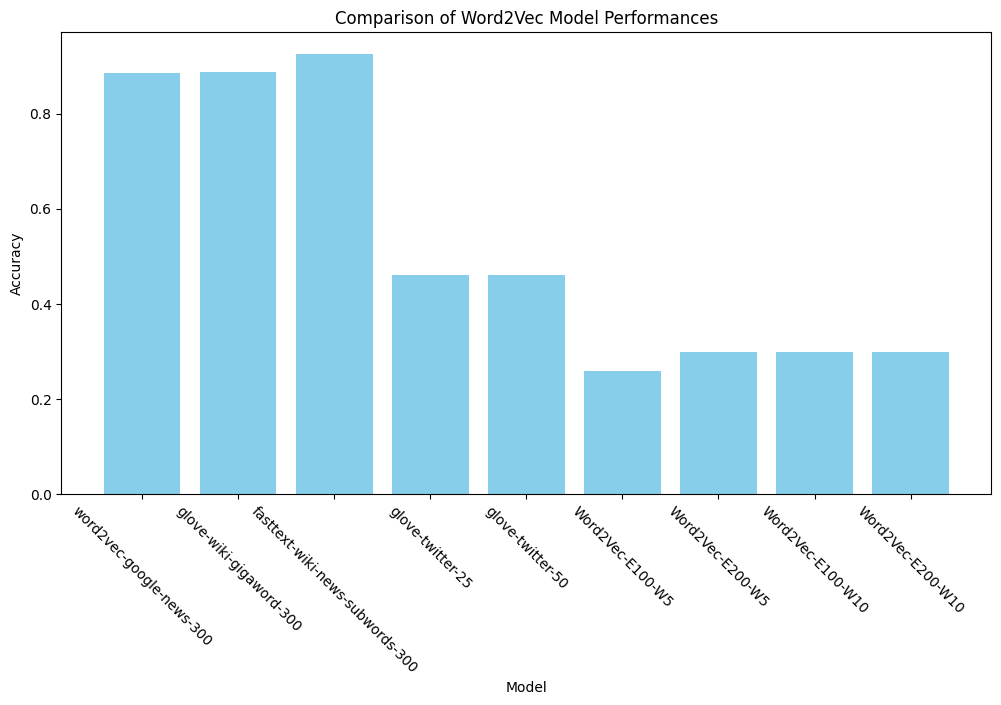

In [71]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(12, 6))
plt.bar(df_task_3_analysis['model_name'], df_task_3_analysis['accuracy'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=-45)
plt.title('Comparison of Word2Vec Model Performances')
plt.savefig('./output/task_3/plot.png')
plt.show()

### Conclusion: Performance Comparison of Word2Vec Models

### Key Observations:
- Models trained on the Gutenberg corpus (`Word2Vec-E5-W100`, `Word2Vec-E5-W200`, etc.) showed varying accuracy, with none exceeding 35%. This contrasts with higher accuracies observed in pre-trained models like `word2vec-google-news-300` and `glove-wiki-gigaword-300`.
- Larger vocabulary sizes in the pre-trained models contributed to their superior performance, highlighting the importance of diverse training data.
- The variation in accuracy between different window sizes and embedding dimensions in the Gutenberg-trained models suggests that these parameters significantly impact the model's ability to capture semantic relationships.

### Speculations on Model Performance:
- **Pre-trained Models** performed better likely due to more extensive and varied training data, leading to more robust word embeddings.
- **Custom Gutenberg Models** had lower accuracy, possibly due to limited context and diversity in the training dataset.
- **Parameter Influence**: The choice of window size and embedding dimensions appears to be crucial, with each configuration offering different strengths, depending on the nature of the text and the task at hand.

### Window Size:

- The window size is a parameter that determines the maximum distance between the current and predicted word within a sentence. 
- In other words, it defines the size of the 'context window' which provides the context words when training word embeddings.
- For example, with a window size of 2, the model considers two words before and two words after the target word as its context.
- A larger window size means more context words and potentially capturing more semantic relationships, but it could also introduce more noise.
- A smaller window size focuses on more local context.

### Embedding (or Embedding Dimensions):

- The term "embedding" refers to the process of converting words into numerical vectors. These vectors capture semantic meaning such that words with similar meaning have similar representation in vector space.
- Embedding dimensions specify the size of these vectors. For instance, an embedding dimension of 300 means each word is represented by a vector with 300 elements.
- The choice of dimensionality is a trade-off: 
  - higher dimensions can capture more nuanced semantics but require more data to learn effectively and can lead to higher computational costs; 
  - lower dimensions are more computationally efficient but might not capture as much semantic detail.

Overall, the analysis underscores the importance of rich and varied training data, along with careful tuning of model parameters, in building effective Word2Vec models for natural language processing tasks.